# Guiding Multimodal Large Language Models with Blind and Low Vision Visual Questions for Proactive Visual Interpretations

This notebook walks through the retrieval pipeline behind our research on Guiding Multimodal Large Language Models (MLLMs) with Blind and Low Vision (BLV) visual questions for proactive visual interpretations.

The goal is to make it a as easy to reproduce or extend by running the cells in order and adapting the pipeline to your own needs if wanted.

### Install dependencies

In [2]:
%pip install -U chromadb google-genai cohere requests pillow python-dotenv pandas numpy tqdm matplotlib

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached posthog-5.4.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached pypika-0.48.9-py2.py3-none-any.whl
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached websockets-15.0.1-cp312-cp312-win_amd64.whl.metadata (7.0 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-

### Import dependencies

In [4]:
import os
import sys
import json
import base64
import random
from io import BytesIO
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from dotenv import load_dotenv
from IPython.display import display

import chromadb
from chromadb.utils import embedding_functions
import cohere
import requests

### Initialize the vector database

Wrapped inside the class `SimpleVectorDB`, located in `src/vector_db.py`.

In [26]:
# load environment variables 
load_dotenv()

# import local modules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# import vectordb wrapper
from src.vector_db import SimpleVectorDB
print("🚀 Initializing Vector Database for image embeddings...")
# import helper for cohere embeddings
from src.embeddings_utils import cohere_generate_image_embedding

# initialize the persistent database
db = SimpleVectorDB()
print("✅ Vector Database initialized successfully!")

🚀 Initializing Vector Database for image embeddings...
Vector DB initialized at: ./data/chroma_db
Persistence enabled: Data will be saved to disk
✅ Vector Database initialized successfully!


### Create a fresh collection or load one

Each experiment uses a dedicated ChromaDB collection to store and query image–question embeddings.
Here we create a new collection for the **VizWiz dataset**, containing 500 random samples using cosine-normalized similarity.  

In [ ]:
print("🗄️ Creating a fresh collection for this experiment...")

# define experiment metadata
experiment_name = "vizwiz_experiment_v2"
collection_name = "vizwiz_500_sample_cosine"
collection_description = "500 random VizWiz samples using cosine-normalized similarity"

# avoid overwriting of an existing collection
existing = db.list_collections()
if collection_name in existing:
    print(f"Collection '{collection_name}' already exists. Reusing existing collection.")
else:
    db.use_collection(collection_name, collection_description)

# Check that the collection is empty before we start
stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")
print("✅ Fresh collection created and ready for embeddings!")


🗄️ Creating a fresh collection for this experiment...
Available collections: []
Collection 'vizwiz_500_sample_cosine' ready
Now using collection: vizwiz_500_sample_cosine
📊 Fresh collection stats: {'total_images': 0, 'collection_name': 'vizwiz_500_sample_cosine', 'persisted': True}
✅ Fresh collection created and ready for embeddings!



### Load VizWiz data and precomputed embeddings

We now load two main components required for this experiment:

1. The **VizWiz dataset** (`all.json`), containing visual questions and metadata.
2. The **precomputed image embeddings**, generated using Cohere’s `embed-v4` model.

If the Chroma collection already contains data, we’ll reuse it.  
Otherwise, we’ll build a fresh sample set of 500 entries from the embeddings.

In [ ]:
print("📝 Loading VizWiz data using pre-computed embeddings...")

# load the original JSON data
data_path = Path("./data/original/all.json")

try:
    with open(data_path, "r") as f:
        all_data = json.load(f)
    print(f"✅ Loaded {len(all_data)} total entries from {data_path.name}")
except FileNotFoundError:
    print(f"❌ File '{data_path}' not found!")
    print("Please make sure the VizWiz data is in ./data/original/")
    all_data = {}

# load precomputed embeddings from cohere's model
embeddings_path = Path("./data/embeddings/lf_vqa_db_embeddings_cohere.json")

try:
    with open(embeddings_path, "r") as f:
        embeddings_data = json.load(f)
    print(f"✅ Loaded pre-computed embeddings from {embeddings_path.name}")

    # Extract IDs and embeddings from file
    embedding_ids = []
    embeddings_dict = {}

    if "items" in embeddings_data:
        for item in embeddings_data["items"]:
            if "id" in item and "embedding" in item:
                item_id = str(item["id"])
                embedding_ids.append(item_id)
                embeddings_dict[item_id] = item["embedding"]

    print(f"📊 Found {len(embedding_ids)} IDs with embeddings in file")

except FileNotFoundError:
    print(f"❌ Embeddings file '{embeddings_path}' not found!")
    print("Please make sure the pre-computed embeddings exist in ./data/embeddings/")
    embedding_ids = []
    embeddings_dict = {}

# check if the collection already contains data
stats = db.get_collection_stats()

if stats.get("total_images", 0) > 0:
    print(f"📊 Found existing collection with {stats['total_images']} entries")

    # get all IDs from the collection
    results = db.current_collection.get()
    existing_ids = results["ids"]
    print(f"🔄 Reusing {len(existing_ids)} existing IDs from collection")

    # extract corresponding data entries
    sample_data = {key: all_data[key] for key in existing_ids if key in all_data}
    print(f"✅ Extracted {len(sample_data)} entries from existing collection")

else:
    # build a new sample dataset from emdeddings
    if embedding_ids and all_data:
        print(f"🎯 Using {len(embedding_ids)} IDs from pre-computed embeddings")
        print(f"🔍 Sample IDs: {embedding_ids[:10]}...")

        sample_data = {}
        for key in embedding_ids:
            if key in all_data:
                sample_data[key] = all_data[key].copy()
                # attach the corresponding embedding vector
                if key in embeddings_dict:
                    sample_data[key]["embedding"] = embeddings_dict[key]

        print(f"✅ Extracted {len(sample_data)} entries for processing")
    
    else:
        sample_data = {}
        print("No embedding IDs or dataset found — using dummy data for testing")

# show example of the extracted data
if sample_data:
    example_key = list(sample_data.keys())[0]
    example_entry = sample_data[example_key]
    print(f"📋 Example entry (ID: {example_key}):")

    for field in ["question", "answerability", "question_type", "crowd_majority", "image_url"]:
        if field in example_entry:
            print(f"  {field}: {example_entry[field]}")

    # display first 10 rows in a dataframe
    print("\n📊 Preview of first 10 sampled entries:")
    sample_rows = [
        {
            "ID": key,
            "Question": data.get("question", "N/A"),
            "Answerability": data.get("answerability", "N/A"),
            "Question Type": data.get("question_type", "N/A"),
            "Crowd Majority": data.get("crowd_majority", "N/A"),
            "Image URL": data.get("image_url", "N/A"),
            "Embedding": "✅" if "embedding" in data else "❌"
        }
        for key, data in list(sample_data.items())[:10]
    ]

    df = pd.DataFrame(sample_rows)
    display(df)




📝 Loading VizWiz data using pre-computed embeddings...
✅ Loaded 600 total entries from all.json
✅ Loaded pre-computed embeddings from lf_vqa_db_embeddings_cohere.json
📊 Found 500 IDs with embeddings in file
🎯 Using 500 IDs from pre-computed embeddings
🔍 Sample IDs: ['596', '39', '416', '56', '31', '230', '372', '433', '308', '377']...
✅ Extracted 500 entries for processing
📋 Example entry (ID: 596):
  question: what is the scientific name of this leaf?
  answerability: unanswerable
  question_type: Others
  crowd_majority: unanswerable
  image_url: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_val_00002308.jpg

📊 Preview of first 10 sampled entries:


,ID,Question,Answerability,Question Type,Crowd Majority,Image URL,Embedding
0,596,what is the scientific name of this leaf?,unanswerable,Others,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
1,39,What is this bottle?,answerable,Identification,febreze,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
2,416,For how long do I cook this in the microwave?,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
3,56,What is this?,answerable,Identification,2 water bottles,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
4,31,What is this?,answerable,Identification,jambalaya mix,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
5,230,What color is this highlighter?,answerable,Description,yellow,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
6,372,when did this expire?,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
7,433,"What time does it say, on my set top box? Than...",answerable,Reading,12:10,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
8,308,What does the label say?,answerable,Reading,chap stick,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅
9,377,What's the warning label?,answerable,Reading,may cause drowsiness,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,✅


### Check collection currently loaded

Before adding any embeddings, we check that the active ChromaDB collection is correctly initialized and persisted to disk.

In [22]:
# fetch stats for the current collection
stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")
print("✅ Collection status check complete!")

📊 Fresh collection stats: {'total_images': 0, 'collection_name': 'vizwiz_500_sample_cosine', 'persisted': True}
✅ Collection status check complete!


### Test embedding functions

In [ ]:

# inspect the first sample entry
first_item = list(sample_data.items())[:1]

if first_item:
    entry_id, entry_data = first_item[0]
    image_url = entry_data.get("image_url", "No image URL found")
    print(f"Entry ID: {entry_id}")
    print(f"Image URL: {image_url}")

    # verify image embedding retrieval
    print("Testing image embedding generation...")
    try:
        test_embedding = cohere_generate_image_embedding(image_url)
        print(f"✅ Embedding generated! Vector length: {len(test_embedding)}")
        print(f"embedding generated", cohere_generate_image_embedding(image_url))
    except Exception as e:
        print(f"❌ Embedding generation failed: {e}")
else:
    print("No data found in sample_data.")


Entry ID: 596
Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_val_00002308.jpg
Testing image embedding generation...
✅ Embedding generated! Vector length: 1536
embedding generated [0.0082283765, -0.012087704, -0.034224223, -0.037865095, 0.00097393396, 0.015582943, 0.017039293, -0.022427788, -0.024321042, -0.00077368587, -0.03349605, 0.012233339, 0.006626392, -0.039903987, 0.0045692977, 0.013179966, -0.027233742, 0.049807165, 0.0015291674, 0.047185734, 0.016675206, 0.022136519, -0.042234145, -0.018422825, -0.0038229183, -0.011068259, 0.010485719, 0.031165887, -0.020680169, 0.027816283, -0.016092665, -0.006517166, -0.015510126, -0.036408745, -0.031020252, 0.024612313, -0.039903987, -0.006772027, 0.037282556, 0.029418267, 0.037865095, 0.010048814, 0.023010328, 0.007500202, 0.032622237, 0.014345046, 0.0026578384, -0.039030176, 0.026214298, -0.027816283, 0.0041141883, -0.007864289, -0.0010831602, -0.043690495, -0.039030176, 0.023592867, 0.029855171, 0.015291673, -0

### Add sample data into the vector database

Now that we’ve loaded the VizWiz samples and their precomputed embeddings,  
we can populate our Chroma collection with these vectors.

Each embedding is stored together with its metadata: including the visual question, answerability, and crowd-sourced answers.

In [29]:
print("🔍 Processing sample data and adding embeddings to the vector database...")

# check current stats 
stats = db.get_collection_stats()
print(f"📊 Current collection stats: {stats}")

# process the sample data if we have it
if sample_data:
    print(f"\n📊 Processing {len(sample_data)} VizWiz entries...")
    
    added_count = 0
    for entry_id, entry_data in list(sample_data.items())[:]:  # Process first 2 for demo
        try:
            image_url = entry_data.get('image_url', '')
            # Generate embedding and normalize it for cosine similarity
            embedding_vector = entry_data.get('embedding', [])
            # Normalize the embedding vector for cosine similarity
            embedding = np.array(embedding_vector)
            embedding = embedding / np.linalg.norm(embedding)
            
            # Extract required fields from VizWiz data
            question = entry_data.get('question', 'No question provided')
            answerability = entry_data.get('answerability', 'unknown')
            question_type = entry_data.get('question_type', 'unknown')
            crowd_answers = entry_data.get('crowd_answers', [])
            crowd_majority = entry_data.get('crowd_majority', 'unknown')
            
            
            # Add to vector database
            db.add_image_embedding(
                embedding_id=entry_id,
                image_embedding=embedding,
                question=question,
                answerability=answerability,
                question_type=question_type,
                image_url=image_url,
                crowd_answers=crowd_answers,
                crowd_majority=crowd_majority
            )
            
            added_count += 1
            
        except Exception as e:
            print(f"❌ Error processing entry {entry_id}: {e}")
    
    print(f"✅ Successfully added {added_count} entries to vector database")
    
# Check updated stats
stats = db.get_collection_stats()
print(f"\n📊 Updated database stats: {stats}")


🔍 Processing sample data and adding embeddings to the vector database...
📊 Current collection stats: {'total_images': 0, 'collection_name': 'None', 'error': 'No collection specified'}

📊 Processing 500 VizWiz entries...
Collection 'default_embeddings' ready
Added embedding 596 to collection 'default_embeddings' (persisted to disk)
Added embedding 39 to collection 'default_embeddings' (persisted to disk)
Added embedding 416 to collection 'default_embeddings' (persisted to disk)
Added embedding 56 to collection 'default_embeddings' (persisted to disk)
Added embedding 31 to collection 'default_embeddings' (persisted to disk)
Added embedding 230 to collection 'default_embeddings' (persisted to disk)
Added embedding 372 to collection 'default_embeddings' (persisted to disk)
Added embedding 433 to collection 'default_embeddings' (persisted to disk)
Added embedding 308 to collection 'default_embeddings' (persisted to disk)
Added embedding 377 to collection 'default_embeddings' (persisted to d

### Testing search

Here we'll check if the embeddings are actually meaningful by retrieving similar images


🚀 Testing Cohere Similarity Search with a Random Query
📁 Loaded validation file with 100 embeddings

🎯 Query ID: 519


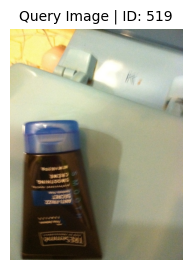

   Question: What are the directions of this product?


------------------------------ SEARCH RESULTS ------------------------------


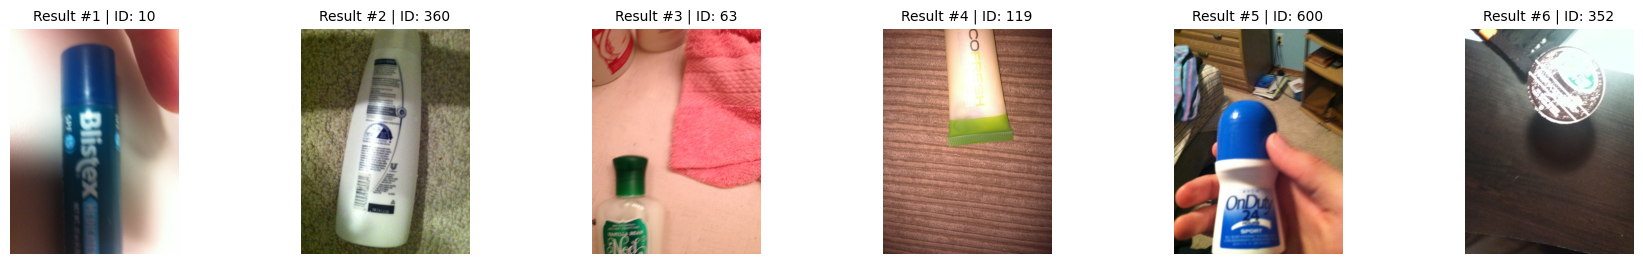

Result #1:
  Question: What is this?
  Answerability: answerable
  Type: Identification
  Crowd Majority: blistex
  Distance: 0.4518

Result #2:
  Question: What are the usages instructions on this shampoo bottle?
  Answerability: unanswerable
  Type: Reading
  Crowd Majority: unanswerable
  Distance: 0.4599

Result #3:
  Question: What is this?
  Answerability: answerable
  Type: Identification
  Crowd Majority: lotion
  Distance: 0.4636

Result #4:
  Question: What is in this bottle?
  Answerability: unanswerable
  Type: Identification
  Crowd Majority: unanswerable
  Distance: 0.4668

Result #5:
  Question: What type of deodorant is this and what's the color of the lid?
  Answerability: answerable
  Type: Others
  Crowd Majority: on duty blue
  Distance: 0.4709

Result #6:
  Question: Are you able to read what is on this K Cup now?
  Answerability: answerable
  Type: Reading
  Crowd Majority: no
  Distance: 0.4849



In [ ]:
# visualization helpers
def show_query_image(url: str, title: str = ""):
    """Download and display a single image."""
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        img = Image.open(BytesIO(resp.content))
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(title, fontsize=10)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Could not display image from {url}: {e}")

def show_results_horizontally(results_list):
    """
    Downloads and displays a list of result images in a single row (smaller),
    with metadata printed below each image.
    """
    if not results_list:
        print("No results to display.")
        return

    num_results = len(results_list)
    fig, axes = plt.subplots(1, num_results, figsize=(3 * num_results, 3))
    if num_results == 1:
        axes = [axes]

    print("\n" + "-"*30 + " SEARCH RESULTS " + "-"*30)
    for i, (ax, result) in enumerate(zip(axes, results_list)):
        metadata = result.get("metadata", {})
        image_url = metadata.get("image_url", "")
        try:
            if image_url:
                resp = requests.get(image_url, timeout=10)
                resp.raise_for_status()
                img = Image.open(BytesIO(resp.content))
                ax.imshow(img)
            else:
                ax.text(0.5, 0.5, "No Image URL", ha="center", va="center", fontsize=8)
        except Exception as e:
            ax.text(0.5, 0.5, f"Image not found:\n{e}", ha="center", va="center", fontsize=8)

        ax.set_title(f"Result #{i+1} | ID: {result.get('id', 'N/A')}", fontsize=10)
        ax.axis("off")

    plt.tight_layout(pad=2.0)
    plt.show()

    # print metadata details
    for i, result in enumerate(results_list):
        meta = result.get("metadata", {})
        dist = result.get("distance", 0.0)
        print(f"Result #{i+1}:")
        print(f"  Question: {meta.get('question', 'N/A')}")
        print(f"  Answerability: {meta.get('answerability', 'N/A')}")
        print(f"  Type: {meta.get('question_type', 'N/A')}")
        print(f"  Crowd Majority: {meta.get('crowd_majority', 'N/A')}")
        print(f"  Distance: {dist:.4f}\n")

# test block 

print("\n" + "="*80)
print("🚀 Testing Cohere Similarity Search with a Random Query")
print("="*80)

validation_file = "./data/embeddings/lf_vqa_validation_embeddings_cohere.json"

try:
    with open(validation_file, "r", encoding="utf-8") as f:
        validation_data = json.load(f)
    print(f"📁 Loaded validation file with {validation_data['count']} embeddings")

    # pick a random embedding
    random_item = random.choice(validation_data["items"])
    query_embedding = random_item["embedding"][0]
    query_meta = random_item["metadata"]
    query_id = random_item["id"]

    # display query
    query_image_url = query_meta.get("image_url")
    print(f"\n🎯 Query ID: {query_id}")
    show_query_image(query_image_url, title=f"Query Image | ID: {query_id}")
    print(f"   Question: {query_meta.get('question', 'N/A')}\n")

    # search in your Chroma collection
    results = db.search_similar_images(query_embedding, n_results=6)

    # filter out the same image ID
    filtered_results = [r for r in results["similar_images"] if r.get("id") != query_id]

    if filtered_results:
        show_results_horizontally(filtered_results)
    else:
        print("No similar images found in the database.")

except FileNotFoundError:
    print(f"❌ File not found: {validation_file}")
except Exception as e:
    print(f"❌ Error during Cohere similarity search: {e}")


### Precalculate embeddings and store

We generate embeddings for a **validation subset** of VizWiz images.  
Each image is passed through Cohere’s `embed-v4.0` model, and the resulting vectors are stored locally in: data/embeddings/lf_vqa_validation_embeddings.json

In [ ]:
import random

print("🧪 Creating validation sample from VizWiz data...")

# Get all IDs already stored in the Chroma collection
existing_snapshot = db.current_collection.get()
existing_ids = set(existing_snapshot["ids"])

# All available VizWiz IDs from the original dataset
all_ids = set(all_data.keys())

# IDs not already in the collection = candidates for validation
remaining_ids = list(all_ids - existing_ids)

if not remaining_ids:
    raise ValueError("No remaining IDs available for validation!")

# Randomly choose up to 100 unseen IDs
validation_sample = random.sample(remaining_ids, min(100, len(remaining_ids)))

print(f"✅ Validation sample created with {len(validation_sample)} IDs.")
print(f"Example IDs: {validation_sample[:5]}")


🧪 Creating validation sample from VizWiz data...
✅ Validation sample created with 100 IDs.
Example IDs: ['285', '237', '568', '354', '489']


In [ ]:
# Generate and save embeddings for validation images
print("\n💾 Generating and saving validation embeddings to disk...")

# Create embeddings directory
os.makedirs("../data/embeddings", exist_ok=True)

# Prepare filename for validation embeddings
validation_filename = "./data/embeddings/lf_vqa_validation_embeddings.json"

# Generate and save validation embeddings
try:
    validation_embeddings = []
    
    print(f"Generating embeddings for {len(validation_sample)} validation images...")
    
    # Extract validation entries from all_data using validation_sample IDs
    for val_id in validation_sample:
        if val_id in all_data:  # Only check if ID exists in original data
            val_entry = all_data[val_id]
            image_url = val_entry.get('image_url', '')
            
            if image_url:
                # Generate embedding for this validation image using original data
                embedding = cohere_generate_image_embedding(image_url)
                
                validation_embeddings.append({
                    "id": val_id,
                    "embedding": embedding,
                    "metadata": {
                        "question": val_entry.get('question', ''),
                        "answerability": val_entry.get('answerability', ''),
                        "question_type": val_entry.get('question_type', ''),
                        "crowd_majority": val_entry.get('crowd_majority', ''),
                        "image_url": image_url
                    }
                })
                print(f"  Generated embedding for validation ID: {val_id} (from original data)")
            else:
                print(f"  ⚠️ No image URL found for validation ID: {val_id}")
        else:
            print(f"  ⚠️ Validation ID {val_id} not found in original data")
    
    # Save validation embeddings to file
    validation_data = {
        "count": len(validation_embeddings),
        "items": validation_embeddings,
    }
    
    with open(validation_filename, 'w') as f:
        json.dump(validation_data, f)
    
    print(f"✅ Saved {len(validation_embeddings)} validation embeddings to {validation_filename}")
    print(f"📊 Success rate: {len(validation_embeddings)}/{len(validation_sample)} validation images processed")
except Exception as e:
    print(f"❌ Error generating validation embeddings: {str(e)}")



💾 Generating and saving validation embeddings to disk...
Generating embeddings for 100 validation images...
  Generated embedding for validation ID: 285 (from original data)
  Generated embedding for validation ID: 237 (from original data)
  Generated embedding for validation ID: 568 (from original data)
  Generated embedding for validation ID: 354 (from original data)
  Generated embedding for validation ID: 489 (from original data)
  Generated embedding for validation ID: 86 (from original data)
  Generated embedding for validation ID: 401 (from original data)
  Generated embedding for validation ID: 52 (from original data)
  Generated embedding for validation ID: 487 (from original data)
  Generated embedding for validation ID: 215 (from original data)
  Generated embedding for validation ID: 548 (from original data)
  Generated embedding for validation ID: 366 (from original data)
  Generated embedding for validation ID: 369 (from original data)
  Generated embedding for validatio